# Обучаем нейросеть для предсказания рейтинга поста

Сегодня мы займёмся тем, что собственноучно обучим нейросеть на датасете постов с Пикабу, который мы подготовили в прошлом воркшопе.

На примере этой задачи мы научимся обучать нейросеть в Tensorflow и посмотрим на разные оптимизаторы.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
# если вы уже используете GPU, есть смысл сказать Tensorflow,
# чтобы он не съедал сразу всю видеопамять,
# не будем перенапрягать видеокарту
GPUs = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(GPUs[0], True)

# если вы работаете на CPU, эта настройка не нужна

In [3]:
# сразу зафиксируем сид для лучшей воспроизводимости результата
np.random.seed(17)
tf.random.set_seed(17)

Вспомним наш датасет

In [4]:
df = pd.read_csv('prepared_posts_df.csv')

In [5]:
df.head()

,nsfw,my,images,videos,text_len,rating,tsin,tcos,in_comm,Длиннопост,...,Своими руками,My Little Pony,Музыка,Мошенничество,Отношения,Стихи,Зима,СССР,Еда,other
0,0,1,2,0,135,683,-0.705620,0.708590,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,1,0,113,480,-0.705414,0.708795,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,301,-0.704950,0.709257,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,4,0,0,425,-0.704537,0.709667,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,726,617,-0.704021,0.710179,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# создадим матрицы признаков и ответов
X = df.drop(columns=['rating']).to_numpy()
Y = df['rating'].to_numpy()

Для обучения разделим наш датасет на 3 части: тренировочную, валидационную и тестовую.

* на тренировочной выборке мы будем обучать нашу нейросеть

* по валидационной выборке будем судить о том, как нейросеть работает с новыми данными и подбирать гиперпараметры

* тестовую выборку откладываем куда подальше: она нужна, чтобы проверить модель уже после того, как она окончательно доделана

In [7]:
# разделим датасет на части: тренировочную, валидационную и тестовую (в пропорции 70/15/15)
# это можно сделать как специальными функциями в фреймворках, так и обычными слайсами

val_frac = 0.15
test_frac = 0.15

x_train = X[:round((1 - val_frac - test_frac) * len(X))]
x_val = X[round((1 - val_frac - test_frac) * len(X)):round((1 - test_frac) * len(X))]
x_test = X[round((1 - test_frac) * len(X)):]

y_train = Y[:round((1 - val_frac - test_frac) * len(Y))]
y_val = Y[round((1 - val_frac - test_frac) * len(Y)):round((1 - test_frac) * len(Y))]
y_test = Y[round((1 - test_frac) * len(Y)):]

In [8]:
x_train.shape, x_val.shape, x_test.shape

((183804, 59), (39386, 59), (39387, 59))

## Строим нашу сетку

По-прежнему будем использовать полносвязную нейросеть, но в этот раз попробуем сделать её побольше. В качестве акцивации используем ReLU, а на последнем слое - линейную, ведь у нас задача регрессии.

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, activation='relu', input_shape=(X.shape[1],)),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               12000     
_________________________________________________________________
dense_1 (Dense)              (None, 500)               100500    
_________________________________________________________________
dense_2 (Dense)              (None, 200)               100200    
_________________________________________________________________
dense_3 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 223,271
Trainable params: 223,271
Non-trainable params: 0
__________________________________________________

In [10]:
# сохраним начальные веса, чтобы в дальнейшем стартовать из одной точки
model.save_weights('initial_weights_59-200-500-200-50-10-1.h5')

Чтобы обучить модель, сначала её нужно скомпилировать: указать параметры тренировки.

В первую очередь, конечно же, нужно выбрать функцию потерь. Т.к. у нас задача регрессии, а последний слой имеет линейную функцию активации, логично будет взять в качестве лосса MSE.

Оптимизировать нейросеть будем при помощи алгоритма Adam. В большинстве случаев он уже неплохо работает "из коробки" и не особо прихотлив в настройках. 

Если в процессе обучения мы хотим оценивать результат по каким-то дополнительным метрикам (помимо лосса), можно указать и их. Давайте на всякий случай ещё будем смотреть на MAE и RMSE.

In [11]:
# компилируем модель

model.compile(
    # указываем функцию потерь
    loss=tf.keras.losses.MSE,

    # выбираем оптимизатор
    optimizer=tf.keras.optimizers.Adam(),

    # можно указать метрики, которые будут считаться на каждом батче
    # и в конце эпохи на трейне и валидации
    # в качестве метрики может выступать и какой-нибудь loss
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

Всё готово для обучения!

По традиции модель обучается методом `fit`. В параметрах, помимо самих обучающих данных, можно также указать данные для валидации: после каждой эпохи мы будем смотреть, как модель ведёт себя на них.

Для начала попробуем сделать 100 проходов (эпох).

In [12]:
# метод fit может вернуть данные о процессе обучения
# по которым удобно анализировать лосс и метрики
history = model.fit(x_train, y_train,
                    # добавим данные для валидации
                    # модель не будет на них тренироваться, но будет считать на них лосс и метрики
                    # по валидации можно отлавливать оверфиттинг прямо во время обучения
                    validation_data=(x_val, y_val),

                    # размер батча данных, пропускаемых через граф за раз
                    # выбирайте из соображений доступной памяти
                    # (или видеопамяти, если используете GPU)
                    batch_size=50000,

                    # эпоха обучения - один проход по всем данным (батчами)
                    epochs=100)

Epoch 1/100
4/4 [==============================] - 1s 156ms/step - loss: 372426.0000 - mean_absolute_error: 442.6693 - root_mean_squared_error: 610.2672 - val_loss: 347514.0312 - val_mean_absolute_error: 439.0567 - val_root_mean_squared_error: 589.5032
Epoch 2/100
4/4 [==============================] - 0s 76ms/step - loss: 347555.5000 - mean_absolute_error: 438.5995 - root_mean_squared_error: 589.5384 - val_loss: 348695.2812 - val_mean_absolute_error: 432.3067 - val_root_mean_squared_error: 590.5043
Epoch 3/100
4/4 [==============================] - 0s 78ms/step - loss: 344918.9062 - mean_absolute_error: 432.9881 - root_mean_squared_error: 587.2980 - val_loss: 344440.7812 - val_mean_absolute_error: 434.3732 - val_root_mean_squared_error: 586.8907
Epoch 4/100
4/4 [==============================] - 0s 76ms/step - loss: 343715.3125 - mean_absolute_error: 433.1913 - root_mean_squared_error: 586.2724 - val_loss: 343926.0625 - val_mean_absolute_error: 433.1645 - val_root_mean_squared_error: 

4/4 [==============================] - 0s 77ms/step - loss: 309358.1875 - mean_absolute_error: 379.0029 - root_mean_squared_error: 556.1998 - val_loss: 307428.5938 - val_mean_absolute_error: 378.1413 - val_root_mean_squared_error: 554.4625
Epoch 34/100
4/4 [==============================] - 0s 76ms/step - loss: 304661.5312 - mean_absolute_error: 376.8818 - root_mean_squared_error: 551.9615 - val_loss: 301739.3125 - val_mean_absolute_error: 373.8374 - val_root_mean_squared_error: 549.3080
Epoch 35/100
4/4 [==============================] - 0s 79ms/step - loss: 296337.3125 - mean_absolute_error: 368.4659 - root_mean_squared_error: 544.3687 - val_loss: 285947.2500 - val_mean_absolute_error: 355.9829 - val_root_mean_squared_error: 534.7404
Epoch 36/100
4/4 [==============================] - 0s 76ms/step - loss: 322717.3125 - mean_absolute_error: 347.5294 - root_mean_squared_error: 568.0822 - val_loss: 293965.2812 - val_mean_absolute_error: 363.7578 - val_root_mean_squared_error: 542.1857
E

4/4 [==============================] - 0s 76ms/step - loss: 310059.8438 - mean_absolute_error: 371.1259 - root_mean_squared_error: 556.8302 - val_loss: 309716.6562 - val_mean_absolute_error: 379.8337 - val_root_mean_squared_error: 556.5219
Epoch 66/100
4/4 [==============================] - 0s 76ms/step - loss: 313865.0000 - mean_absolute_error: 382.8238 - root_mean_squared_error: 560.2366 - val_loss: 311065.8438 - val_mean_absolute_error: 380.9848 - val_root_mean_squared_error: 557.7328
Epoch 67/100
4/4 [==============================] - 0s 77ms/step - loss: 306335.3438 - mean_absolute_error: 375.9737 - root_mean_squared_error: 553.4757 - val_loss: 307860.5938 - val_mean_absolute_error: 371.3232 - val_root_mean_squared_error: 554.8519
Epoch 68/100
4/4 [==============================] - 0s 79ms/step - loss: 307001.5312 - mean_absolute_error: 370.0311 - root_mean_squared_error: 554.0772 - val_loss: 308110.1875 - val_mean_absolute_error: 371.1054 - val_root_mean_squared_error: 555.0767
E

4/4 [==============================] - 0s 77ms/step - loss: 305404.9062 - mean_absolute_error: 377.1718 - root_mean_squared_error: 552.6345 - val_loss: 304394.7500 - val_mean_absolute_error: 374.2354 - val_root_mean_squared_error: 551.7198
Epoch 98/100
4/4 [==============================] - 0s 80ms/step - loss: 303178.5312 - mean_absolute_error: 372.2283 - root_mean_squared_error: 550.6165 - val_loss: 305323.0625 - val_mean_absolute_error: 371.1362 - val_root_mean_squared_error: 552.5605
Epoch 99/100
4/4 [==============================] - 0s 76ms/step - loss: 302739.5625 - mean_absolute_error: 369.5955 - root_mean_squared_error: 550.2177 - val_loss: 303393.4062 - val_mean_absolute_error: 369.9345 - val_root_mean_squared_error: 550.8116
Epoch 100/100
4/4 [==============================] - 0s 76ms/step - loss: 300695.1250 - mean_absolute_error: 368.6706 - root_mean_squared_error: 548.3568 - val_loss: 301082.3125 - val_mean_absolute_error: 369.6407 - val_root_mean_squared_error: 548.7097


Ура, работает!

В объекте `history` у нас сохранились данные о значениях лосса и метрик на каждой эпохе. Давайте на них посмотрим:

In [13]:
import matplotlib.pyplot as plt

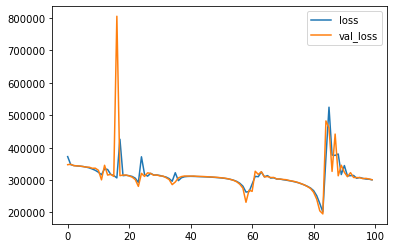

In [14]:
# посмотрим, как оптимизируется функция потерь
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Видим, что значение лосса сильно скачет, при этом не особо спешит идти вниз.

Такое поведение может свидетельствовать о слишком большом learning rate: алгоритм делает большие шаги и "скачет" вокруг какой-то ямки, но всё никак в неё не попадёт. Скорее всего, рано или поздно Adam и сам адаптирует lr, но мы можем ему немного помочь...

Параметры оптимизатора можно указывать прям в скобках. Описание всех параметров можно посмотреть в документации Keras: https://keras.io/api/optimizers/adam/

In [15]:
# перекомпилируем модель с более низким lr и продолжим обучение
model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

history2 = model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     batch_size=50000,
                     epochs=100)

Epoch 1/100
4/4 [==============================] - 1s 145ms/step - loss: 299120.6562 - mean_absolute_error: 367.5390 - root_mean_squared_error: 546.9193 - val_loss: 299986.8750 - val_mean_absolute_error: 367.7408 - val_root_mean_squared_error: 547.7106
Epoch 2/100
4/4 [==============================] - 0s 79ms/step - loss: 297712.0312 - mean_absolute_error: 365.8858 - root_mean_squared_error: 545.6299 - val_loss: 298562.2500 - val_mean_absolute_error: 366.5007 - val_root_mean_squared_error: 546.4085
Epoch 3/100
4/4 [==============================] - 0s 72ms/step - loss: 296227.3750 - mean_absolute_error: 364.4143 - root_mean_squared_error: 544.2678 - val_loss: 297106.0000 - val_mean_absolute_error: 364.8822 - val_root_mean_squared_error: 545.0743
Epoch 4/100
4/4 [==============================] - 0s 72ms/step - loss: 294530.7812 - mean_absolute_error: 362.4615 - root_mean_squared_error: 542.7069 - val_loss: 295445.2500 - val_mean_absolute_error: 362.8494 - val_root_mean_squared_error: 

4/4 [==============================] - 0s 78ms/step - loss: 165242.3438 - mean_absolute_error: 247.3406 - root_mean_squared_error: 406.5001 - val_loss: 163654.3281 - val_mean_absolute_error: 246.2750 - val_root_mean_squared_error: 404.5421
Epoch 34/100
4/4 [==============================] - 0s 77ms/step - loss: 164876.5625 - mean_absolute_error: 246.9398 - root_mean_squared_error: 406.0500 - val_loss: 163287.5938 - val_mean_absolute_error: 245.8781 - val_root_mean_squared_error: 404.0886
Epoch 35/100
4/4 [==============================] - 0s 78ms/step - loss: 164367.1719 - mean_absolute_error: 246.4612 - root_mean_squared_error: 405.4222 - val_loss: 162910.6875 - val_mean_absolute_error: 245.4307 - val_root_mean_squared_error: 403.6219
Epoch 36/100
4/4 [==============================] - 0s 72ms/step - loss: 163907.2969 - mean_absolute_error: 245.9957 - root_mean_squared_error: 404.8547 - val_loss: 162430.2812 - val_mean_absolute_error: 244.9272 - val_root_mean_squared_error: 403.0264
E

4/4 [==============================] - 0s 72ms/step - loss: 153198.6719 - mean_absolute_error: 236.6544 - root_mean_squared_error: 391.4060 - val_loss: 153788.6094 - val_mean_absolute_error: 237.6449 - val_root_mean_squared_error: 392.1589
Epoch 66/100
4/4 [==============================] - 0s 74ms/step - loss: 153531.8906 - mean_absolute_error: 236.9423 - root_mean_squared_error: 391.8315 - val_loss: 151489.2656 - val_mean_absolute_error: 235.4715 - val_root_mean_squared_error: 389.2162
Epoch 67/100
4/4 [==============================] - 0s 73ms/step - loss: 152511.1094 - mean_absolute_error: 236.1900 - root_mean_squared_error: 390.5267 - val_loss: 151622.2969 - val_mean_absolute_error: 235.3626 - val_root_mean_squared_error: 389.3871
Epoch 68/100
4/4 [==============================] - 0s 71ms/step - loss: 152598.4219 - mean_absolute_error: 236.2136 - root_mean_squared_error: 390.6385 - val_loss: 151159.1094 - val_mean_absolute_error: 235.1193 - val_root_mean_squared_error: 388.7919
E

4/4 [==============================] - 0s 69ms/step - loss: 150145.0781 - mean_absolute_error: 234.1017 - root_mean_squared_error: 387.4856 - val_loss: 150009.3125 - val_mean_absolute_error: 234.4890 - val_root_mean_squared_error: 387.3104
Epoch 98/100
4/4 [==============================] - 0s 70ms/step - loss: 150032.0000 - mean_absolute_error: 233.9709 - root_mean_squared_error: 387.3396 - val_loss: 149020.1094 - val_mean_absolute_error: 233.2990 - val_root_mean_squared_error: 386.0312
Epoch 99/100
4/4 [==============================] - 0s 76ms/step - loss: 149798.6250 - mean_absolute_error: 233.7570 - root_mean_squared_error: 387.0383 - val_loss: 148951.0000 - val_mean_absolute_error: 233.2345 - val_root_mean_squared_error: 385.9417
Epoch 100/100
4/4 [==============================] - 0s 66ms/step - loss: 149753.6250 - mean_absolute_error: 233.6944 - root_mean_squared_error: 386.9801 - val_loss: 148860.6719 - val_mean_absolute_error: 233.0945 - val_root_mean_squared_error: 385.8247


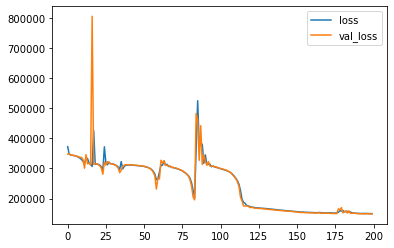

In [16]:
# посмотрим на новый график
plt.plot(history.history['loss'] + history2.history['loss'])
plt.plot(history.history['val_loss'] + history2.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Выглядит просто отлично! Давайте продолжим обучение:

In [17]:
history3 = model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     batch_size=50000,
                     epochs=500)  # на этот раз побольше эпох

Epoch 1/500
4/4 [==============================] - 0s 97ms/step - loss: 149709.2812 - mean_absolute_error: 233.6593 - root_mean_squared_error: 386.9229 - val_loss: 148926.3125 - val_mean_absolute_error: 232.9555 - val_root_mean_squared_error: 385.9097
Epoch 2/500
4/4 [==============================] - 0s 79ms/step - loss: 149787.5469 - mean_absolute_error: 233.6968 - root_mean_squared_error: 387.0240 - val_loss: 148886.3438 - val_mean_absolute_error: 232.9058 - val_root_mean_squared_error: 385.8579
Epoch 3/500
4/4 [==============================] - 0s 84ms/step - loss: 149945.6406 - mean_absolute_error: 233.7717 - root_mean_squared_error: 387.2281 - val_loss: 148716.6250 - val_mean_absolute_error: 232.9473 - val_root_mean_squared_error: 385.6379
Epoch 4/500
4/4 [==============================] - 0s 87ms/step - loss: 150022.7969 - mean_absolute_error: 233.8662 - root_mean_squared_error: 387.3278 - val_loss: 148940.5312 - val_mean_absolute_error: 233.3322 - val_root_mean_squared_error: 3

4/4 [==============================] - 0s 81ms/step - loss: 148828.4219 - mean_absolute_error: 232.6340 - root_mean_squared_error: 385.7828 - val_loss: 147575.1562 - val_mean_absolute_error: 231.4055 - val_root_mean_squared_error: 384.1551
Epoch 34/500
4/4 [==============================] - 0s 81ms/step - loss: 148856.3906 - mean_absolute_error: 232.4291 - root_mean_squared_error: 385.8191 - val_loss: 147609.4062 - val_mean_absolute_error: 231.3736 - val_root_mean_squared_error: 384.1997
Epoch 35/500
4/4 [==============================] - 0s 79ms/step - loss: 149046.2969 - mean_absolute_error: 232.5911 - root_mean_squared_error: 386.0652 - val_loss: 149807.9531 - val_mean_absolute_error: 234.3403 - val_root_mean_squared_error: 387.0503
Epoch 36/500
4/4 [==============================] - 0s 79ms/step - loss: 148945.0625 - mean_absolute_error: 232.6101 - root_mean_squared_error: 385.9340 - val_loss: 148175.7969 - val_mean_absolute_error: 232.5959 - val_root_mean_squared_error: 384.9361
E

4/4 [==============================] - 0s 72ms/step - loss: 147147.2188 - mean_absolute_error: 230.6511 - root_mean_squared_error: 383.5977 - val_loss: 146363.9531 - val_mean_absolute_error: 229.9324 - val_root_mean_squared_error: 382.5754
Epoch 66/500
4/4 [==============================] - 0s 75ms/step - loss: 147189.5000 - mean_absolute_error: 230.5571 - root_mean_squared_error: 383.6528 - val_loss: 146532.2500 - val_mean_absolute_error: 230.5140 - val_root_mean_squared_error: 382.7953
Epoch 67/500
4/4 [==============================] - 0s 74ms/step - loss: 147371.1562 - mean_absolute_error: 230.8170 - root_mean_squared_error: 383.8895 - val_loss: 146797.0469 - val_mean_absolute_error: 230.9533 - val_root_mean_squared_error: 383.1410
Epoch 68/500
4/4 [==============================] - 0s 73ms/step - loss: 147359.4844 - mean_absolute_error: 230.9165 - root_mean_squared_error: 383.8743 - val_loss: 147422.4062 - val_mean_absolute_error: 230.3486 - val_root_mean_squared_error: 383.9563
E

4/4 [==============================] - 0s 76ms/step - loss: 145825.5312 - mean_absolute_error: 228.8729 - root_mean_squared_error: 381.8711 - val_loss: 145395.5000 - val_mean_absolute_error: 228.6340 - val_root_mean_squared_error: 381.3076
Epoch 98/500
4/4 [==============================] - 0s 70ms/step - loss: 145814.1875 - mean_absolute_error: 228.8098 - root_mean_squared_error: 381.8562 - val_loss: 145413.4531 - val_mean_absolute_error: 228.5231 - val_root_mean_squared_error: 381.3311
Epoch 99/500
4/4 [==============================] - 0s 71ms/step - loss: 145823.3594 - mean_absolute_error: 228.8469 - root_mean_squared_error: 381.8682 - val_loss: 145759.9531 - val_mean_absolute_error: 229.5459 - val_root_mean_squared_error: 381.7852
Epoch 100/500
4/4 [==============================] - 0s 72ms/step - loss: 146018.3125 - mean_absolute_error: 229.1769 - root_mean_squared_error: 382.1234 - val_loss: 145763.3281 - val_mean_absolute_error: 228.6168 - val_root_mean_squared_error: 381.7896


Epoch 129/500
4/4 [==============================] - 0s 77ms/step - loss: 147867.4219 - mean_absolute_error: 230.3326 - root_mean_squared_error: 384.5353 - val_loss: 146090.3594 - val_mean_absolute_error: 228.0200 - val_root_mean_squared_error: 382.2177
Epoch 130/500
4/4 [==============================] - 0s 73ms/step - loss: 147014.7812 - mean_absolute_error: 229.1056 - root_mean_squared_error: 383.4251 - val_loss: 145899.2500 - val_mean_absolute_error: 227.8360 - val_root_mean_squared_error: 381.9676
Epoch 131/500
4/4 [==============================] - 0s 71ms/step - loss: 145911.3906 - mean_absolute_error: 228.2944 - root_mean_squared_error: 381.9835 - val_loss: 144620.4531 - val_mean_absolute_error: 227.8468 - val_root_mean_squared_error: 380.2899
Epoch 132/500
4/4 [==============================] - 0s 76ms/step - loss: 145046.2969 - mean_absolute_error: 227.6630 - root_mean_squared_error: 380.8494 - val_loss: 145106.1250 - val_mean_absolute_error: 228.5187 - val_root_mean_squared_

4/4 [==============================] - 0s 71ms/step - loss: 144051.9531 - mean_absolute_error: 226.2821 - root_mean_squared_error: 379.5418 - val_loss: 143650.2344 - val_mean_absolute_error: 225.8138 - val_root_mean_squared_error: 379.0122
Epoch 162/500
4/4 [==============================] - 0s 71ms/step - loss: 144040.6250 - mean_absolute_error: 226.0339 - root_mean_squared_error: 379.5269 - val_loss: 143797.0000 - val_mean_absolute_error: 226.6247 - val_root_mean_squared_error: 379.2057
Epoch 163/500
4/4 [==============================] - 0s 74ms/step - loss: 143845.6094 - mean_absolute_error: 226.0984 - root_mean_squared_error: 379.2698 - val_loss: 143460.9219 - val_mean_absolute_error: 225.8738 - val_root_mean_squared_error: 378.7624
Epoch 164/500
4/4 [==============================] - 0s 73ms/step - loss: 143774.2656 - mean_absolute_error: 225.8930 - root_mean_squared_error: 379.1758 - val_loss: 143471.9219 - val_mean_absolute_error: 225.7104 - val_root_mean_squared_error: 378.776

4/4 [==============================] - 0s 67ms/step - loss: 143158.7656 - mean_absolute_error: 224.7753 - root_mean_squared_error: 378.3633 - val_loss: 142981.7969 - val_mean_absolute_error: 224.5829 - val_root_mean_squared_error: 378.1293
Epoch 194/500
4/4 [==============================] - 0s 69ms/step - loss: 143298.0781 - mean_absolute_error: 224.7730 - root_mean_squared_error: 378.5473 - val_loss: 142814.9219 - val_mean_absolute_error: 224.8169 - val_root_mean_squared_error: 377.9086
Epoch 195/500
4/4 [==============================] - 0s 70ms/step - loss: 142997.4219 - mean_absolute_error: 224.5834 - root_mean_squared_error: 378.1500 - val_loss: 142929.4688 - val_mean_absolute_error: 225.1223 - val_root_mean_squared_error: 378.0602
Epoch 196/500
4/4 [==============================] - 0s 68ms/step - loss: 143053.4688 - mean_absolute_error: 224.6648 - root_mean_squared_error: 378.2241 - val_loss: 143016.4688 - val_mean_absolute_error: 224.4751 - val_root_mean_squared_error: 378.175

4/4 [==============================] - 0s 68ms/step - loss: 143690.9219 - mean_absolute_error: 224.6313 - root_mean_squared_error: 379.0659 - val_loss: 142522.8906 - val_mean_absolute_error: 223.2489 - val_root_mean_squared_error: 377.5220
Epoch 226/500
4/4 [==============================] - 0s 71ms/step - loss: 143033.1719 - mean_absolute_error: 223.8885 - root_mean_squared_error: 378.1973 - val_loss: 144069.5625 - val_mean_absolute_error: 223.8803 - val_root_mean_squared_error: 379.5650
Epoch 227/500
4/4 [==============================] - 0s 70ms/step - loss: 143689.9844 - mean_absolute_error: 224.2374 - root_mean_squared_error: 379.0646 - val_loss: 143345.0469 - val_mean_absolute_error: 223.4437 - val_root_mean_squared_error: 378.6093
Epoch 228/500
4/4 [==============================] - 0s 70ms/step - loss: 142986.9062 - mean_absolute_error: 223.7235 - root_mean_squared_error: 378.1361 - val_loss: 142651.2031 - val_mean_absolute_error: 223.1179 - val_root_mean_squared_error: 377.692

4/4 [==============================] - 0s 107ms/step - loss: 141416.5312 - mean_absolute_error: 221.5135 - root_mean_squared_error: 376.0539 - val_loss: 141081.4531 - val_mean_absolute_error: 221.3892 - val_root_mean_squared_error: 375.6081
Epoch 258/500
4/4 [==============================] - 0s 90ms/step - loss: 141585.7031 - mean_absolute_error: 221.6062 - root_mean_squared_error: 376.2787 - val_loss: 142136.5156 - val_mean_absolute_error: 221.3937 - val_root_mean_squared_error: 377.0100
Epoch 259/500
4/4 [==============================] - 0s 75ms/step - loss: 142857.8125 - mean_absolute_error: 222.2977 - root_mean_squared_error: 377.9654 - val_loss: 141382.0625 - val_mean_absolute_error: 221.1735 - val_root_mean_squared_error: 376.0081
Epoch 260/500
4/4 [==============================] - 0s 82ms/step - loss: 146437.5156 - mean_absolute_error: 224.8081 - root_mean_squared_error: 382.6715 - val_loss: 151909.4844 - val_mean_absolute_error: 233.6798 - val_root_mean_squared_error: 389.75

4/4 [==============================] - 0s 69ms/step - loss: 146333.7500 - mean_absolute_error: 224.3722 - root_mean_squared_error: 382.5360 - val_loss: 143518.9375 - val_mean_absolute_error: 224.7918 - val_root_mean_squared_error: 378.8389
Epoch 290/500
4/4 [==============================] - 0s 69ms/step - loss: 144196.6875 - mean_absolute_error: 222.3746 - root_mean_squared_error: 379.7324 - val_loss: 142437.0625 - val_mean_absolute_error: 223.1991 - val_root_mean_squared_error: 377.4084
Epoch 291/500
4/4 [==============================] - 0s 70ms/step - loss: 142609.3594 - mean_absolute_error: 220.9282 - root_mean_squared_error: 377.6365 - val_loss: 144686.5312 - val_mean_absolute_error: 225.4766 - val_root_mean_squared_error: 380.3768
Epoch 292/500
4/4 [==============================] - 0s 70ms/step - loss: 143472.9844 - mean_absolute_error: 221.2281 - root_mean_squared_error: 378.7783 - val_loss: 148517.1719 - val_mean_absolute_error: 229.4594 - val_root_mean_squared_error: 385.379

Epoch 321/500
4/4 [==============================] - 0s 77ms/step - loss: 140698.2969 - mean_absolute_error: 217.4610 - root_mean_squared_error: 375.0977 - val_loss: 142502.8438 - val_mean_absolute_error: 217.7223 - val_root_mean_squared_error: 377.4955
Epoch 322/500
4/4 [==============================] - 0s 79ms/step - loss: 142522.6250 - mean_absolute_error: 218.8571 - root_mean_squared_error: 377.5217 - val_loss: 144421.8750 - val_mean_absolute_error: 219.0018 - val_root_mean_squared_error: 380.0288
Epoch 323/500
4/4 [==============================] - 0s 86ms/step - loss: 144531.6406 - mean_absolute_error: 220.4377 - root_mean_squared_error: 380.1732 - val_loss: 141894.2031 - val_mean_absolute_error: 217.3894 - val_root_mean_squared_error: 376.6885
Epoch 324/500
4/4 [==============================] - 0s 78ms/step - loss: 144418.8281 - mean_absolute_error: 219.7571 - root_mean_squared_error: 380.0248 - val_loss: 141356.5938 - val_mean_absolute_error: 219.5368 - val_root_mean_squared_

4/4 [==============================] - 0s 77ms/step - loss: 137371.5625 - mean_absolute_error: 212.6926 - root_mean_squared_error: 370.6367 - val_loss: 137236.9219 - val_mean_absolute_error: 212.0182 - val_root_mean_squared_error: 370.4550
Epoch 354/500
4/4 [==============================] - 0s 83ms/step - loss: 136958.0625 - mean_absolute_error: 212.2416 - root_mean_squared_error: 370.0785 - val_loss: 136705.2031 - val_mean_absolute_error: 212.1601 - val_root_mean_squared_error: 369.7367
Epoch 355/500
4/4 [==============================] - 0s 80ms/step - loss: 136830.4219 - mean_absolute_error: 212.0686 - root_mean_squared_error: 369.9060 - val_loss: 138234.9844 - val_mean_absolute_error: 215.0469 - val_root_mean_squared_error: 371.7997
Epoch 356/500
4/4 [==============================] - 0s 71ms/step - loss: 137472.3594 - mean_absolute_error: 212.8303 - root_mean_squared_error: 370.7726 - val_loss: 137612.5312 - val_mean_absolute_error: 211.6845 - val_root_mean_squared_error: 370.961

4/4 [==============================] - 0s 79ms/step - loss: 138445.9062 - mean_absolute_error: 211.2379 - root_mean_squared_error: 372.0832 - val_loss: 135258.2344 - val_mean_absolute_error: 208.5169 - val_root_mean_squared_error: 367.7747
Epoch 386/500
4/4 [==============================] - 0s 73ms/step - loss: 136079.3125 - mean_absolute_error: 209.5681 - root_mean_squared_error: 368.8893 - val_loss: 135241.0781 - val_mean_absolute_error: 208.8219 - val_root_mean_squared_error: 367.7514
Epoch 387/500
4/4 [==============================] - 0s 69ms/step - loss: 135703.1250 - mean_absolute_error: 208.9533 - root_mean_squared_error: 368.3791 - val_loss: 135716.1562 - val_mean_absolute_error: 209.3939 - val_root_mean_squared_error: 368.3967
Epoch 388/500
4/4 [==============================] - 0s 77ms/step - loss: 135502.3750 - mean_absolute_error: 208.6955 - root_mean_squared_error: 368.1065 - val_loss: 135558.2188 - val_mean_absolute_error: 209.4722 - val_root_mean_squared_error: 368.182

4/4 [==============================] - 0s 73ms/step - loss: 132836.8906 - mean_absolute_error: 204.1295 - root_mean_squared_error: 364.4680 - val_loss: 133171.8750 - val_mean_absolute_error: 205.1102 - val_root_mean_squared_error: 364.9272
Epoch 418/500
4/4 [==============================] - 0s 76ms/step - loss: 132454.2656 - mean_absolute_error: 203.9960 - root_mean_squared_error: 363.9427 - val_loss: 132961.1250 - val_mean_absolute_error: 203.6219 - val_root_mean_squared_error: 364.6383
Epoch 419/500
4/4 [==============================] - 0s 78ms/step - loss: 132800.4219 - mean_absolute_error: 204.1479 - root_mean_squared_error: 364.4179 - val_loss: 133003.4688 - val_mean_absolute_error: 203.3943 - val_root_mean_squared_error: 364.6964
Epoch 420/500
4/4 [==============================] - 0s 78ms/step - loss: 132174.0312 - mean_absolute_error: 203.2084 - root_mean_squared_error: 363.5575 - val_loss: 132522.3281 - val_mean_absolute_error: 203.5212 - val_root_mean_squared_error: 364.036

4/4 [==============================] - 0s 86ms/step - loss: 134148.2031 - mean_absolute_error: 205.6867 - root_mean_squared_error: 366.2625 - val_loss: 134438.4688 - val_mean_absolute_error: 205.8894 - val_root_mean_squared_error: 366.6585
Epoch 450/500
4/4 [==============================] - 0s 86ms/step - loss: 133994.4062 - mean_absolute_error: 205.4207 - root_mean_squared_error: 366.0525 - val_loss: 134280.0312 - val_mean_absolute_error: 205.3954 - val_root_mean_squared_error: 366.4424
Epoch 451/500
4/4 [==============================] - 0s 97ms/step - loss: 133844.0781 - mean_absolute_error: 205.1361 - root_mean_squared_error: 365.8471 - val_loss: 134156.6875 - val_mean_absolute_error: 205.1069 - val_root_mean_squared_error: 366.2740
Epoch 452/500
4/4 [==============================] - 0s 85ms/step - loss: 133797.8594 - mean_absolute_error: 204.8620 - root_mean_squared_error: 365.7839 - val_loss: 134089.0156 - val_mean_absolute_error: 204.7421 - val_root_mean_squared_error: 366.181

Epoch 481/500
4/4 [==============================] - 0s 76ms/step - loss: 131914.6875 - mean_absolute_error: 200.5688 - root_mean_squared_error: 363.2006 - val_loss: 133066.5469 - val_mean_absolute_error: 200.5481 - val_root_mean_squared_error: 364.7829
Epoch 482/500
4/4 [==============================] - 0s 83ms/step - loss: 131973.3438 - mean_absolute_error: 200.5030 - root_mean_squared_error: 363.2813 - val_loss: 132529.2188 - val_mean_absolute_error: 200.0885 - val_root_mean_squared_error: 364.0456
Epoch 483/500
4/4 [==============================] - 0s 77ms/step - loss: 131598.0781 - mean_absolute_error: 200.2786 - root_mean_squared_error: 362.7645 - val_loss: 131620.2656 - val_mean_absolute_error: 199.3263 - val_root_mean_squared_error: 362.7951
Epoch 484/500
4/4 [==============================] - 0s 76ms/step - loss: 130864.4609 - mean_absolute_error: 199.4997 - root_mean_squared_error: 361.7519 - val_loss: 130634.0156 - val_mean_absolute_error: 198.9751 - val_root_mean_squared_

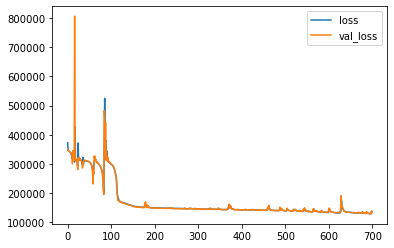

In [18]:
# посмотрим на новый график
plt.plot(history.history['loss'] + history2.history['loss'] + history3.history['loss'])
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

Неплохо, но опять пошли небольшие скачки. Давайте ещё уменьшим lr, чтобы уже окончательно "дожать" нашу сетку.

In [19]:
# ещё уменьшим lr
model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    metrics=[tf.keras.metrics.MeanAbsoluteError(),
             tf.keras.metrics.RootMeanSquaredError()]
)

history4 = model.fit(x_train, y_train,
                     validation_data=(x_val, y_val),
                     batch_size=50000,
                     epochs=500)

Epoch 1/500
4/4 [==============================] - 1s 142ms/step - loss: 131770.1250 - mean_absolute_error: 199.3146 - root_mean_squared_error: 363.0016 - val_loss: 131084.2969 - val_mean_absolute_error: 198.1676 - val_root_mean_squared_error: 362.0557
Epoch 2/500
4/4 [==============================] - 0s 77ms/step - loss: 130397.3984 - mean_absolute_error: 198.5764 - root_mean_squared_error: 361.1058 - val_loss: 131125.6562 - val_mean_absolute_error: 199.8176 - val_root_mean_squared_error: 362.1128
Epoch 3/500
4/4 [==============================] - 0s 75ms/step - loss: 129954.3359 - mean_absolute_error: 198.1352 - root_mean_squared_error: 360.4918 - val_loss: 130731.9219 - val_mean_absolute_error: 197.7140 - val_root_mean_squared_error: 361.5687
Epoch 4/500
4/4 [==============================] - 0s 79ms/step - loss: 129950.4375 - mean_absolute_error: 197.1762 - root_mean_squared_error: 360.4864 - val_loss: 130272.6562 - val_mean_absolute_error: 198.0445 - val_root_mean_squared_error: 

4/4 [==============================] - 0s 75ms/step - loss: 128068.3906 - mean_absolute_error: 195.2054 - root_mean_squared_error: 357.8665 - val_loss: 128786.5391 - val_mean_absolute_error: 195.9108 - val_root_mean_squared_error: 358.8684
Epoch 34/500
4/4 [==============================] - 0s 68ms/step - loss: 128011.1172 - mean_absolute_error: 195.1335 - root_mean_squared_error: 357.7864 - val_loss: 128755.0000 - val_mean_absolute_error: 195.8140 - val_root_mean_squared_error: 358.8245
Epoch 35/500
4/4 [==============================] - 0s 75ms/step - loss: 127983.6797 - mean_absolute_error: 195.1601 - root_mean_squared_error: 357.7481 - val_loss: 128721.6797 - val_mean_absolute_error: 195.7236 - val_root_mean_squared_error: 358.7780
Epoch 36/500
4/4 [==============================] - 0s 73ms/step - loss: 127990.3516 - mean_absolute_error: 195.1711 - root_mean_squared_error: 357.7574 - val_loss: 128719.1641 - val_mean_absolute_error: 195.6036 - val_root_mean_squared_error: 358.7745
E

4/4 [==============================] - 0s 75ms/step - loss: 127739.3125 - mean_absolute_error: 194.7121 - root_mean_squared_error: 357.4064 - val_loss: 128541.5625 - val_mean_absolute_error: 195.0524 - val_root_mean_squared_error: 358.5269
Epoch 66/500
4/4 [==============================] - 0s 70ms/step - loss: 127776.8828 - mean_absolute_error: 194.6520 - root_mean_squared_error: 357.4589 - val_loss: 128422.6641 - val_mean_absolute_error: 195.1049 - val_root_mean_squared_error: 358.3611
Epoch 67/500
4/4 [==============================] - 0s 71ms/step - loss: 127682.9766 - mean_absolute_error: 194.5154 - root_mean_squared_error: 357.3275 - val_loss: 128446.6094 - val_mean_absolute_error: 195.2921 - val_root_mean_squared_error: 358.3945
Epoch 68/500
4/4 [==============================] - 0s 72ms/step - loss: 127671.7812 - mean_absolute_error: 194.5327 - root_mean_squared_error: 357.3119 - val_loss: 128487.7812 - val_mean_absolute_error: 195.4305 - val_root_mean_squared_error: 358.4519
E

4/4 [==============================] - 0s 73ms/step - loss: 127398.4297 - mean_absolute_error: 194.0382 - root_mean_squared_error: 356.9292 - val_loss: 128165.2500 - val_mean_absolute_error: 194.6341 - val_root_mean_squared_error: 358.0017
Epoch 98/500
4/4 [==============================] - 0s 72ms/step - loss: 127396.4453 - mean_absolute_error: 194.0897 - root_mean_squared_error: 356.9264 - val_loss: 128333.2031 - val_mean_absolute_error: 194.4903 - val_root_mean_squared_error: 358.2362
Epoch 99/500
4/4 [==============================] - 0s 75ms/step - loss: 127474.6875 - mean_absolute_error: 194.1187 - root_mean_squared_error: 357.0360 - val_loss: 128147.5938 - val_mean_absolute_error: 194.5725 - val_root_mean_squared_error: 357.9771
Epoch 100/500
4/4 [==============================] - 0s 75ms/step - loss: 127408.9922 - mean_absolute_error: 193.9388 - root_mean_squared_error: 356.9440 - val_loss: 128208.1484 - val_mean_absolute_error: 194.8365 - val_root_mean_squared_error: 358.0616


4/4 [==============================] - 0s 72ms/step - loss: 127112.4922 - mean_absolute_error: 193.5021 - root_mean_squared_error: 356.5284 - val_loss: 128001.8750 - val_mean_absolute_error: 193.9130 - val_root_mean_squared_error: 357.7735
Epoch 130/500
4/4 [==============================] - 0s 76ms/step - loss: 127218.6016 - mean_absolute_error: 193.6210 - root_mean_squared_error: 356.6772 - val_loss: 127912.6328 - val_mean_absolute_error: 193.8845 - val_root_mean_squared_error: 357.6487
Epoch 131/500
4/4 [==============================] - 0s 72ms/step - loss: 127135.0547 - mean_absolute_error: 193.3807 - root_mean_squared_error: 356.5600 - val_loss: 127925.9141 - val_mean_absolute_error: 194.1873 - val_root_mean_squared_error: 357.6673
Epoch 132/500
4/4 [==============================] - 0s 74ms/step - loss: 127126.3203 - mean_absolute_error: 193.3597 - root_mean_squared_error: 356.5478 - val_loss: 127991.3125 - val_mean_absolute_error: 194.4305 - val_root_mean_squared_error: 357.758

4/4 [==============================] - 0s 73ms/step - loss: 126844.9688 - mean_absolute_error: 192.9082 - root_mean_squared_error: 356.1530 - val_loss: 127576.9688 - val_mean_absolute_error: 193.4471 - val_root_mean_squared_error: 357.1792
Epoch 162/500
4/4 [==============================] - 0s 74ms/step - loss: 126803.6953 - mean_absolute_error: 192.8726 - root_mean_squared_error: 356.0951 - val_loss: 127564.2266 - val_mean_absolute_error: 193.5016 - val_root_mean_squared_error: 357.1613
Epoch 163/500
4/4 [==============================] - 0s 75ms/step - loss: 126805.4375 - mean_absolute_error: 192.9070 - root_mean_squared_error: 356.0975 - val_loss: 127597.3750 - val_mean_absolute_error: 193.3268 - val_root_mean_squared_error: 357.2077
Epoch 164/500
4/4 [==============================] - 0s 73ms/step - loss: 126824.1094 - mean_absolute_error: 192.8649 - root_mean_squared_error: 356.1237 - val_loss: 127548.9453 - val_mean_absolute_error: 193.3932 - val_root_mean_squared_error: 357.140

4/4 [==============================] - 0s 68ms/step - loss: 126584.4688 - mean_absolute_error: 192.4650 - root_mean_squared_error: 355.7871 - val_loss: 127341.5703 - val_mean_absolute_error: 192.9075 - val_root_mean_squared_error: 356.8495
Epoch 194/500
4/4 [==============================] - 0s 68ms/step - loss: 126591.7031 - mean_absolute_error: 192.3945 - root_mean_squared_error: 355.7973 - val_loss: 127303.6641 - val_mean_absolute_error: 192.9791 - val_root_mean_squared_error: 356.7964
Epoch 195/500
4/4 [==============================] - 0s 67ms/step - loss: 126546.0859 - mean_absolute_error: 192.3117 - root_mean_squared_error: 355.7332 - val_loss: 127455.2656 - val_mean_absolute_error: 193.4272 - val_root_mean_squared_error: 357.0088
Epoch 196/500
4/4 [==============================] - 0s 69ms/step - loss: 126536.3047 - mean_absolute_error: 192.3900 - root_mean_squared_error: 355.7194 - val_loss: 127285.9609 - val_mean_absolute_error: 192.9905 - val_root_mean_squared_error: 356.771

4/4 [==============================] - 0s 67ms/step - loss: 126295.9375 - mean_absolute_error: 191.9108 - root_mean_squared_error: 355.3814 - val_loss: 127282.8828 - val_mean_absolute_error: 193.1281 - val_root_mean_squared_error: 356.7673
Epoch 226/500
4/4 [==============================] - 0s 69ms/step - loss: 126354.6172 - mean_absolute_error: 191.9662 - root_mean_squared_error: 355.4640 - val_loss: 127157.8750 - val_mean_absolute_error: 192.8590 - val_root_mean_squared_error: 356.5920
Epoch 227/500
4/4 [==============================] - 0s 69ms/step - loss: 126281.7578 - mean_absolute_error: 191.8684 - root_mean_squared_error: 355.3615 - val_loss: 127110.6094 - val_mean_absolute_error: 192.7548 - val_root_mean_squared_error: 356.5258
Epoch 228/500
4/4 [==============================] - 0s 71ms/step - loss: 126247.3125 - mean_absolute_error: 191.8407 - root_mean_squared_error: 355.3130 - val_loss: 127042.8203 - val_mean_absolute_error: 192.6014 - val_root_mean_squared_error: 356.430

4/4 [==============================] - 0s 71ms/step - loss: 125971.9453 - mean_absolute_error: 191.3144 - root_mean_squared_error: 354.9253 - val_loss: 126839.9062 - val_mean_absolute_error: 192.1969 - val_root_mean_squared_error: 356.1459
Epoch 258/500
4/4 [==============================] - 0s 69ms/step - loss: 126007.4688 - mean_absolute_error: 191.3418 - root_mean_squared_error: 354.9753 - val_loss: 126884.5625 - val_mean_absolute_error: 192.3948 - val_root_mean_squared_error: 356.2086
Epoch 259/500
4/4 [==============================] - 0s 70ms/step - loss: 125957.6406 - mean_absolute_error: 191.3785 - root_mean_squared_error: 354.9051 - val_loss: 126753.3438 - val_mean_absolute_error: 191.8702 - val_root_mean_squared_error: 356.0244
Epoch 260/500
4/4 [==============================] - 0s 68ms/step - loss: 125938.0469 - mean_absolute_error: 191.2385 - root_mean_squared_error: 354.8775 - val_loss: 126745.2812 - val_mean_absolute_error: 192.0264 - val_root_mean_squared_error: 356.013

4/4 [==============================] - 0s 70ms/step - loss: 125688.1250 - mean_absolute_error: 190.7783 - root_mean_squared_error: 354.5252 - val_loss: 126500.2812 - val_mean_absolute_error: 191.5212 - val_root_mean_squared_error: 355.6688
Epoch 290/500
4/4 [==============================] - 0s 69ms/step - loss: 125649.1172 - mean_absolute_error: 190.7159 - root_mean_squared_error: 354.4702 - val_loss: 126509.6172 - val_mean_absolute_error: 191.5876 - val_root_mean_squared_error: 355.6819
Epoch 291/500
4/4 [==============================] - 0s 69ms/step - loss: 125652.8984 - mean_absolute_error: 190.7726 - root_mean_squared_error: 354.4755 - val_loss: 126465.5312 - val_mean_absolute_error: 191.4690 - val_root_mean_squared_error: 355.6199
Epoch 292/500
4/4 [==============================] - 0s 70ms/step - loss: 125648.1719 - mean_absolute_error: 190.7497 - root_mean_squared_error: 354.4689 - val_loss: 126470.9453 - val_mean_absolute_error: 191.4744 - val_root_mean_squared_error: 355.627

4/4 [==============================] - 0s 71ms/step - loss: 125570.5625 - mean_absolute_error: 190.4191 - root_mean_squared_error: 354.3594 - val_loss: 126569.0391 - val_mean_absolute_error: 191.6631 - val_root_mean_squared_error: 355.7654
Epoch 322/500
4/4 [==============================] - 0s 73ms/step - loss: 125490.9531 - mean_absolute_error: 190.3334 - root_mean_squared_error: 354.2470 - val_loss: 126249.8984 - val_mean_absolute_error: 191.1515 - val_root_mean_squared_error: 355.3166
Epoch 323/500
4/4 [==============================] - 0s 75ms/step - loss: 125387.0391 - mean_absolute_error: 190.2418 - root_mean_squared_error: 354.1003 - val_loss: 126319.1719 - val_mean_absolute_error: 191.2365 - val_root_mean_squared_error: 355.4141
Epoch 324/500
4/4 [==============================] - 0s 72ms/step - loss: 125446.2969 - mean_absolute_error: 190.2766 - root_mean_squared_error: 354.1840 - val_loss: 126258.7500 - val_mean_absolute_error: 191.1517 - val_root_mean_squared_error: 355.329

4/4 [==============================] - 0s 69ms/step - loss: 125067.3438 - mean_absolute_error: 189.7032 - root_mean_squared_error: 353.6486 - val_loss: 125916.7734 - val_mean_absolute_error: 190.3532 - val_root_mean_squared_error: 354.8475
Epoch 354/500
4/4 [==============================] - 0s 68ms/step - loss: 125048.0938 - mean_absolute_error: 189.5936 - root_mean_squared_error: 353.6214 - val_loss: 125915.0391 - val_mean_absolute_error: 190.3356 - val_root_mean_squared_error: 354.8451
Epoch 355/500
4/4 [==============================] - 0s 69ms/step - loss: 125068.9062 - mean_absolute_error: 189.6676 - root_mean_squared_error: 353.6508 - val_loss: 125905.0312 - val_mean_absolute_error: 190.3195 - val_root_mean_squared_error: 354.8310
Epoch 356/500
4/4 [==============================] - 0s 67ms/step - loss: 125073.0078 - mean_absolute_error: 189.6642 - root_mean_squared_error: 353.6566 - val_loss: 125923.0625 - val_mean_absolute_error: 190.2320 - val_root_mean_squared_error: 354.856

4/4 [==============================] - 0s 70ms/step - loss: 124700.0469 - mean_absolute_error: 189.0522 - root_mean_squared_error: 353.1289 - val_loss: 125593.8359 - val_mean_absolute_error: 189.6648 - val_root_mean_squared_error: 354.3922
Epoch 386/500
4/4 [==============================] - 0s 71ms/step - loss: 124699.3125 - mean_absolute_error: 188.9428 - root_mean_squared_error: 353.1279 - val_loss: 125566.2266 - val_mean_absolute_error: 189.6816 - val_root_mean_squared_error: 354.3532
Epoch 387/500
4/4 [==============================] - 0s 69ms/step - loss: 124685.3906 - mean_absolute_error: 188.9547 - root_mean_squared_error: 353.1082 - val_loss: 125545.2578 - val_mean_absolute_error: 189.6952 - val_root_mean_squared_error: 354.3237
Epoch 388/500
4/4 [==============================] - 0s 78ms/step - loss: 124669.4062 - mean_absolute_error: 188.8979 - root_mean_squared_error: 353.0855 - val_loss: 125569.8672 - val_mean_absolute_error: 189.6077 - val_root_mean_squared_error: 354.358

4/4 [==============================] - 0s 71ms/step - loss: 124436.8672 - mean_absolute_error: 188.4603 - root_mean_squared_error: 352.7561 - val_loss: 125350.3828 - val_mean_absolute_error: 189.5470 - val_root_mean_squared_error: 354.0486
Epoch 418/500
4/4 [==============================] - 0s 70ms/step - loss: 124396.1328 - mean_absolute_error: 188.3199 - root_mean_squared_error: 352.6984 - val_loss: 125218.2812 - val_mean_absolute_error: 189.1606 - val_root_mean_squared_error: 353.8619
Epoch 419/500
4/4 [==============================] - 0s 70ms/step - loss: 124281.6016 - mean_absolute_error: 188.2403 - root_mean_squared_error: 352.5359 - val_loss: 125144.1797 - val_mean_absolute_error: 189.1969 - val_root_mean_squared_error: 353.7572
Epoch 420/500
4/4 [==============================] - 0s 71ms/step - loss: 124274.9844 - mean_absolute_error: 188.2025 - root_mean_squared_error: 352.5266 - val_loss: 125604.4219 - val_mean_absolute_error: 189.8600 - val_root_mean_squared_error: 354.407

4/4 [==============================] - 0s 69ms/step - loss: 123730.7734 - mean_absolute_error: 187.4617 - root_mean_squared_error: 351.7538 - val_loss: 124606.9141 - val_mean_absolute_error: 187.9856 - val_root_mean_squared_error: 352.9970
Epoch 450/500
4/4 [==============================] - 0s 69ms/step - loss: 123729.5547 - mean_absolute_error: 187.3850 - root_mean_squared_error: 351.7521 - val_loss: 124594.3672 - val_mean_absolute_error: 188.0057 - val_root_mean_squared_error: 352.9793
Epoch 451/500
4/4 [==============================] - 0s 70ms/step - loss: 123670.4609 - mean_absolute_error: 187.4204 - root_mean_squared_error: 351.6681 - val_loss: 124557.8750 - val_mean_absolute_error: 187.9758 - val_root_mean_squared_error: 352.9276
Epoch 452/500
4/4 [==============================] - 0s 69ms/step - loss: 123678.7500 - mean_absolute_error: 187.2839 - root_mean_squared_error: 351.6799 - val_loss: 124554.3672 - val_mean_absolute_error: 187.9075 - val_root_mean_squared_error: 352.922

4/4 [==============================] - 0s 79ms/step - loss: 123198.7109 - mean_absolute_error: 186.5883 - root_mean_squared_error: 350.9967 - val_loss: 124280.0000 - val_mean_absolute_error: 187.3519 - val_root_mean_squared_error: 352.5337
Epoch 482/500
4/4 [==============================] - 0s 76ms/step - loss: 123271.4922 - mean_absolute_error: 186.6481 - root_mean_squared_error: 351.1004 - val_loss: 124125.1875 - val_mean_absolute_error: 187.3515 - val_root_mean_squared_error: 352.3141
Epoch 483/500
4/4 [==============================] - 0s 71ms/step - loss: 123177.7969 - mean_absolute_error: 186.5665 - root_mean_squared_error: 350.9669 - val_loss: 124138.3672 - val_mean_absolute_error: 187.4173 - val_root_mean_squared_error: 352.3328
Epoch 484/500
4/4 [==============================] - 0s 68ms/step - loss: 123170.0312 - mean_absolute_error: 186.5692 - root_mean_squared_error: 350.9559 - val_loss: 124184.7109 - val_mean_absolute_error: 187.5118 - val_root_mean_squared_error: 352.398

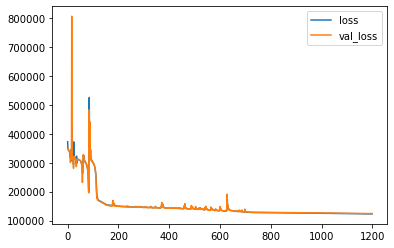

In [20]:
# посмотрим на новый график
plt.plot(history.history['loss'] + history2.history['loss'] + history3.history['loss'] + history4.history['loss'])
plt.plot(history.history['val_loss'] + history2.history['val_loss'] + history3.history['val_loss'] + history4.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

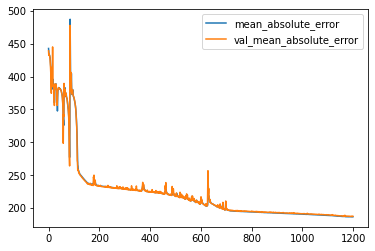

In [21]:
# аналогично можно посмотреть и на значения метрик
plt.plot(history.history['mean_absolute_error'] + history2.history['mean_absolute_error'] +
         history3.history['mean_absolute_error'] + history4.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'] + history2.history['val_mean_absolute_error']
         + history3.history['val_mean_absolute_error'] + history4.history['val_mean_absolute_error'])
plt.legend(['mean_absolute_error', 'val_mean_absolute_error'])
plt.show()

Мы видим, что модель уже вышла на плато, при этом значения лосса и ошибки на трейне и валидации практически не отличаются. Благо, данных достаточно много, а поэтому переобучения не произошло.

Значит, есть надежда, что и на тестовых данных результат будет аналогичный. 

Для того, чтобы прогнать модель на тестовых данных, используем метод `evaluate`.

In [22]:
# проверим модель на тестовой выборке
model.evaluate(x_test, y_test)

1231/1231 [==============================] - 4s 3ms/step - loss: 136082.5000 - mean_absolute_error: 188.4818 - root_mean_squared_error: 368.8936


[136082.5, 188.48179626464844, 368.89361572265625]

## Давайте посмотрим на разные оптимизаторы

Мы с вами упоминали ещё пару более-менее продвинутых алгоритмов, предшественников Adam'а: Adagrad и RMSProp.

Давайте обучим одну и ту же архитектуру на одних и тех же данных, стартуя с одних и тех же весов, но используя разные алгоритмы. 

Сделаем несколько моделей, отличающихся только алгоритмами оптимизации:

In [23]:
# чтобы не копипастить постоянно одно и то же, 
# сделаем функцию, возвращающую базовую модель
def create_basic_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(200, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
    ])

    model.load_weights('initial_weights_59-200-500-200-50-10-1.h5')

    return model


# и скомпилируем её с разными оптимизаторами

# Adagrad
adagrad_model = create_basic_model()
adagrad_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0001)
)

# RMSProp
RMSProp_model = create_basic_model()
RMSProp_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001)
)

# Adam
adam_model = create_basic_model()
adam_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
)

Epoch 1/400
4/4 [==============================] - 0s 68ms/step - loss: 371548.7188
Epoch 2/400
4/4 [==============================] - 0s 67ms/step - loss: 352034.0312
Epoch 3/400
4/4 [==============================] - 0s 70ms/step - loss: 346548.3125 0s - loss: 34429
Epoch 4/400
4/4 [==============================] - 0s 65ms/step - loss: 344952.4062
Epoch 5/400
4/4 [==============================] - 0s 63ms/step - loss: 344539.6875
Epoch 6/400
4/4 [==============================] - 0s 62ms/step - loss: 344447.9062
Epoch 7/400
4/4 [==============================] - 0s 63ms/step - loss: 344426.5625
Epoch 8/400
4/4 [==============================] - 0s 62ms/step - loss: 344418.3750
Epoch 9/400
4/4 [==============================] - 0s 62ms/step - loss: 344398.0000
Epoch 10/400
4/4 [==============================] - 0s 62ms/step - loss: 344393.2188
Epoch 11/400
4/4 [==============================] - 0s 66ms/step - loss: 344381.3438
Epoch 12/400
4/4 [==============================] - 0s 64

4/4 [==============================] - 0s 59ms/step - loss: 343658.4062
Epoch 98/400
4/4 [==============================] - 0s 59ms/step - loss: 343645.1250
Epoch 99/400
4/4 [==============================] - 0s 60ms/step - loss: 343638.4688
Epoch 100/400
4/4 [==============================] - 0s 62ms/step - loss: 343629.1562
Epoch 101/400
4/4 [==============================] - 0s 61ms/step - loss: 343620.7500
Epoch 102/400
4/4 [==============================] - 0s 67ms/step - loss: 343619.2812
Epoch 103/400
4/4 [==============================] - 0s 77ms/step - loss: 343607.1562
Epoch 104/400
4/4 [==============================] - 0s 68ms/step - loss: 343615.2812
Epoch 105/400
4/4 [==============================] - 0s 61ms/step - loss: 343592.9375
Epoch 106/400
4/4 [==============================] - 0s 67ms/step - loss: 343586.3438
Epoch 107/400
4/4 [==============================] - 0s 62ms/step - loss: 343577.8750
Epoch 108/400
4/4 [==============================] - 0s 67ms/step - lo

4/4 [==============================] - 0s 59ms/step - loss: 342816.2812
Epoch 193/400
4/4 [==============================] - 0s 56ms/step - loss: 342814.6875
Epoch 194/400
4/4 [==============================] - 0s 65ms/step - loss: 342798.4062
Epoch 195/400
4/4 [==============================] - 0s 57ms/step - loss: 342793.2188
Epoch 196/400
4/4 [==============================] - 0s 58ms/step - loss: 342779.5000
Epoch 197/400
4/4 [==============================] - 0s 63ms/step - loss: 342774.4688
Epoch 198/400
4/4 [==============================] - 0s 56ms/step - loss: 342772.3750
Epoch 199/400
4/4 [==============================] - 0s 63ms/step - loss: 342760.0312
Epoch 200/400
4/4 [==============================] - 0s 59ms/step - loss: 342754.4375
Epoch 201/400
4/4 [==============================] - 0s 57ms/step - loss: 342730.8438
Epoch 202/400
4/4 [==============================] - 0s 61ms/step - loss: 342687.9375
Epoch 203/400
4/4 [==============================] - 0s 62ms/step - 

4/4 [==============================] - 0s 54ms/step - loss: 341564.1875
Epoch 288/400
4/4 [==============================] - 0s 56ms/step - loss: 341535.4375
Epoch 289/400
4/4 [==============================] - 0s 58ms/step - loss: 341534.1875
Epoch 290/400
4/4 [==============================] - 0s 59ms/step - loss: 341544.0000
Epoch 291/400
4/4 [==============================] - 0s 55ms/step - loss: 341514.7812
Epoch 292/400
4/4 [==============================] - 0s 57ms/step - loss: 341492.2812
Epoch 293/400
4/4 [==============================] - 0s 57ms/step - loss: 341506.4062
Epoch 294/400
4/4 [==============================] - 0s 54ms/step - loss: 341477.9688
Epoch 295/400
4/4 [==============================] - 0s 57ms/step - loss: 341487.1875
Epoch 296/400
4/4 [==============================] - 0s 57ms/step - loss: 341450.8125
Epoch 297/400
4/4 [==============================] - 0s 54ms/step - loss: 341435.7500
Epoch 298/400
4/4 [==============================] - 0s 57ms/step - 

4/4 [==============================] - 0s 58ms/step - loss: 340197.9375
Epoch 383/400
4/4 [==============================] - 0s 56ms/step - loss: 340143.9062
Epoch 384/400
4/4 [==============================] - 0s 58ms/step - loss: 340084.9375
Epoch 385/400
4/4 [==============================] - 0s 58ms/step - loss: 340055.4688
Epoch 386/400
4/4 [==============================] - 0s 56ms/step - loss: 340024.5625
Epoch 387/400
4/4 [==============================] - 0s 58ms/step - loss: 340022.7500
Epoch 388/400
4/4 [==============================] - 0s 56ms/step - loss: 339998.2500
Epoch 389/400
4/4 [==============================] - 0s 56ms/step - loss: 339973.1250
Epoch 390/400
4/4 [==============================] - 0s 56ms/step - loss: 339959.5000 0s - loss: 343480.
Epoch 391/400
4/4 [==============================] - 0s 55ms/step - loss: 339955.0000
Epoch 392/400
4/4 [==============================] - 0s 56ms/step - loss: 339940.4375
Epoch 393/400
4/4 [==============================

4/4 [==============================] - 0s 57ms/step - loss: 332738.1562
Epoch 78/400
4/4 [==============================] - 0s 59ms/step - loss: 324161.3438
Epoch 79/400
4/4 [==============================] - 0s 57ms/step - loss: 321500.1250
Epoch 80/400
4/4 [==============================] - 0s 59ms/step - loss: 326911.3438
Epoch 81/400
4/4 [==============================] - 0s 59ms/step - loss: 332648.5000
Epoch 82/400
4/4 [==============================] - 0s 60ms/step - loss: 321410.2188
Epoch 83/400
4/4 [==============================] - 0s 58ms/step - loss: 316721.0000
Epoch 84/400
4/4 [==============================] - 0s 57ms/step - loss: 314947.0312
Epoch 85/400
4/4 [==============================] - 0s 59ms/step - loss: 327321.2500
Epoch 86/400
4/4 [==============================] - 0s 59ms/step - loss: 311841.1562
Epoch 87/400
4/4 [==============================] - 0s 58ms/step - loss: 311152.5625
Epoch 88/400
4/4 [==============================] - 0s 58ms/step - loss: 31901

4/4 [==============================] - 0s 59ms/step - loss: 249345.4531
Epoch 173/400
4/4 [==============================] - 0s 60ms/step - loss: 233841.2969
Epoch 174/400
4/4 [==============================] - 0s 58ms/step - loss: 279386.2812
Epoch 175/400
4/4 [==============================] - 0s 56ms/step - loss: 259193.2969
Epoch 176/400
4/4 [==============================] - 0s 59ms/step - loss: 244314.6250
Epoch 177/400
4/4 [==============================] - 0s 61ms/step - loss: 227887.5156
Epoch 178/400
4/4 [==============================] - 0s 59ms/step - loss: 275956.3438
Epoch 179/400
4/4 [==============================] - 0s 59ms/step - loss: 254492.3125
Epoch 180/400
4/4 [==============================] - 0s 59ms/step - loss: 232951.5938
Epoch 181/400
4/4 [==============================] - 0s 59ms/step - loss: 237642.6719
Epoch 182/400
4/4 [==============================] - 0s 58ms/step - loss: 222827.0625
Epoch 183/400
4/4 [==============================] - 0s 56ms/step - 

4/4 [==============================] - 0s 63ms/step - loss: 257594.3750
Epoch 268/400
4/4 [==============================] - 0s 59ms/step - loss: 238590.5938
Epoch 269/400
4/4 [==============================] - 0s 66ms/step - loss: 222850.8594
Epoch 270/400
4/4 [==============================] - 0s 60ms/step - loss: 195399.5312
Epoch 271/400
4/4 [==============================] - 0s 62ms/step - loss: 239082.7344
Epoch 272/400
4/4 [==============================] - 0s 61ms/step - loss: 197828.0000
Epoch 273/400
4/4 [==============================] - 0s 60ms/step - loss: 230538.5469
Epoch 274/400
4/4 [==============================] - 0s 61ms/step - loss: 205080.3594
Epoch 275/400
4/4 [==============================] - 0s 58ms/step - loss: 198918.5781
Epoch 276/400
4/4 [==============================] - 0s 63ms/step - loss: 210910.8438
Epoch 277/400
4/4 [==============================] - 0s 63ms/step - loss: 221303.0000
Epoch 278/400
4/4 [==============================] - 0s 58ms/step - 

4/4 [==============================] - 0s 59ms/step - loss: 177146.9062
Epoch 363/400
4/4 [==============================] - 0s 59ms/step - loss: 218599.5156
Epoch 364/400
4/4 [==============================] - 0s 59ms/step - loss: 191740.0000
Epoch 365/400
4/4 [==============================] - 0s 57ms/step - loss: 215287.6250
Epoch 366/400
4/4 [==============================] - 0s 57ms/step - loss: 224672.3281
Epoch 367/400
4/4 [==============================] - 0s 57ms/step - loss: 197352.7344
Epoch 368/400
4/4 [==============================] - 0s 60ms/step - loss: 186216.5156
Epoch 369/400
4/4 [==============================] - 0s 59ms/step - loss: 184956.2812
Epoch 370/400
4/4 [==============================] - 0s 58ms/step - loss: 253624.1875
Epoch 371/400
4/4 [==============================] - 0s 57ms/step - loss: 231022.3438
Epoch 372/400
4/4 [==============================] - 0s 57ms/step - loss: 216174.5312
Epoch 373/400
4/4 [==============================] - 0s 57ms/step - 

4/4 [==============================] - 0s 55ms/step - loss: 273382.7500
Epoch 59/400
4/4 [==============================] - 0s 56ms/step - loss: 269758.6875
Epoch 60/400
4/4 [==============================] - 0s 58ms/step - loss: 283966.8750
Epoch 61/400
4/4 [==============================] - 0s 56ms/step - loss: 283296.5625
Epoch 62/400
4/4 [==============================] - 0s 57ms/step - loss: 277757.9375
Epoch 63/400
4/4 [==============================] - 0s 58ms/step - loss: 270378.3750
Epoch 64/400
4/4 [==============================] - 0s 57ms/step - loss: 261287.1094
Epoch 65/400
4/4 [==============================] - 0s 59ms/step - loss: 258342.4688
Epoch 66/400
4/4 [==============================] - 0s 58ms/step - loss: 253062.7344
Epoch 67/400
4/4 [==============================] - 0s 56ms/step - loss: 248679.0156
Epoch 68/400
4/4 [==============================] - 0s 58ms/step - loss: 249054.9531
Epoch 69/400
4/4 [==============================] - 0s 57ms/step - loss: 23941

4/4 [==============================] - 0s 57ms/step - loss: 159445.4844
Epoch 154/400
4/4 [==============================] - 0s 56ms/step - loss: 158938.7188
Epoch 155/400
4/4 [==============================] - 0s 58ms/step - loss: 158375.8438
Epoch 156/400
4/4 [==============================] - 0s 57ms/step - loss: 157606.3125
Epoch 157/400
4/4 [==============================] - 0s 57ms/step - loss: 158465.5469
Epoch 158/400
4/4 [==============================] - 0s 57ms/step - loss: 157341.5469
Epoch 159/400
4/4 [==============================] - 0s 55ms/step - loss: 157147.0469
Epoch 160/400
4/4 [==============================] - 0s 57ms/step - loss: 156502.8125
Epoch 161/400
4/4 [==============================] - 0s 57ms/step - loss: 156960.8594
Epoch 162/400
4/4 [==============================] - 0s 59ms/step - loss: 156098.1875
Epoch 163/400
4/4 [==============================] - 0s 57ms/step - loss: 156380.7812
Epoch 164/400
4/4 [==============================] - 0s 59ms/step - 

4/4 [==============================] - 0s 66ms/step - loss: 149176.1562
Epoch 249/400
4/4 [==============================] - 0s 57ms/step - loss: 148644.8125
Epoch 250/400
4/4 [==============================] - 0s 58ms/step - loss: 148269.4062
Epoch 251/400
4/4 [==============================] - 0s 57ms/step - loss: 147976.6094
Epoch 252/400
4/4 [==============================] - 0s 57ms/step - loss: 147681.8281
Epoch 253/400
4/4 [==============================] - 0s 57ms/step - loss: 147329.7500
Epoch 254/400
4/4 [==============================] - 0s 57ms/step - loss: 147031.2969
Epoch 255/400
4/4 [==============================] - 0s 59ms/step - loss: 146696.5938
Epoch 256/400
4/4 [==============================] - 0s 56ms/step - loss: 146555.5000
Epoch 257/400
4/4 [==============================] - 0s 56ms/step - loss: 146408.2031
Epoch 258/400
4/4 [==============================] - 0s 58ms/step - loss: 146681.0000
Epoch 259/400
4/4 [==============================] - 0s 58ms/step - 

4/4 [==============================] - 0s 57ms/step - loss: 249739.2031 0s - loss: 260353.
Epoch 344/400
4/4 [==============================] - 0s 60ms/step - loss: 239543.3750
Epoch 345/400
4/4 [==============================] - 0s 56ms/step - loss: 231020.5312
Epoch 346/400
4/4 [==============================] - 0s 57ms/step - loss: 221347.0625
Epoch 347/400
4/4 [==============================] - 0s 59ms/step - loss: 204073.8750
Epoch 348/400
4/4 [==============================] - 0s 57ms/step - loss: 192422.9688
Epoch 349/400
4/4 [==============================] - 0s 57ms/step - loss: 173760.1250
Epoch 350/400
4/4 [==============================] - 0s 57ms/step - loss: 162173.2969
Epoch 351/400
4/4 [==============================] - 0s 58ms/step - loss: 156723.4531
Epoch 352/400
4/4 [==============================] - 0s 57ms/step - loss: 152277.7188
Epoch 353/400
4/4 [==============================] - 0s 57ms/step - loss: 150175.0312
Epoch 354/400
4/4 [==============================

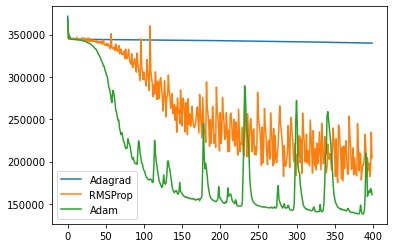

In [24]:
# обучим каждую модель в течение 400 эпох
# и нарисуем график изменения функции потерь
for m in [adagrad_model, RMSProp_model, adam_model]:
    history = m.fit(x_train, y_train,
                    batch_size=50000,
                    epochs=400)
    plt.plot(history.history['loss'])

plt.legend(['Adagrad', 'RMSProp', 'Adam'])
plt.show()

Видим, что `Adagrad` немного скакнула вниз, но сразу же куда-то упёрлась. Скорее всего, она попала в седловую точку и её "адаптивности" не хватает, чтобы оттуда выбраться, либо lr для неё слишком большой. В общем, в любом случае нужно играть с параметрами.

У `RMSProp` всё получше: его "кобасит" (но это нормально), но он всё равно верно идёт к минимуму.

Тем не менее, `Adam` справляется быстрее всех.

В любом случае с каждой задачей и архитектурой разные оптимизаторы работают по-разному, и всегда есть смысл попробоать перебрать несколько вариантов. Но "из коробки" Adam в большинстве случаев уже неплох. 

## А что, если всё-таки не ReLU?

Мы с вами говорили о том, что зачастую ReLU оказывается лучше сигмоидальных функций из-за проблемы затухающих градиентов. Малые значения производных перемножаются, "накапливаются", веса сдвигаются меньше и обучение идёт сложнее.

Давайте попробуем заменить в нашей нейросети все функции активации на сигмоиду и сами посмотрим, как будет идти обучение.

In [25]:
# сравним, как будут обучаться модели с релу и сигмоидой

relu_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(200, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(500, activation='relu'),
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(50, activation='relu'),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
    ])

sigma_model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(200, activation='sigmoid', input_shape=(X.shape[1],)),
        tf.keras.layers.Dense(500, activation='sigmoid'),
        tf.keras.layers.Dense(200, activation='sigmoid'),
        tf.keras.layers.Dense(50, activation='sigmoid'),
        tf.keras.layers.Dense(10, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
    ])

# загрузим им одинаковые начальные веса
relu_model.load_weights('initial_weights_59-200-500-200-50-10-1.h5')
sigma_model.load_weights('initial_weights_59-200-500-200-50-10-1.h5')

# и уже заранее установим сигме в несколько раз больший rl:
# если сделать такой же, как у ReLU, обучение будет идти 
# совсем черепашьими темпами
relu_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001)
)
sigma_model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1)  # сразу уже сделаем lr побольше
)

Epoch 1/400
4/4 [==============================] - 0s 73ms/step - loss: 369258.0938
Epoch 2/400
4/4 [==============================] - 0s 67ms/step - loss: 345690.7188
Epoch 3/400
4/4 [==============================] - 0s 70ms/step - loss: 349285.3125
Epoch 4/400
4/4 [==============================] - 0s 63ms/step - loss: 347266.4375
Epoch 5/400
4/4 [==============================] - 0s 63ms/step - loss: 344554.9375
Epoch 6/400
4/4 [==============================] - 0s 63ms/step - loss: 344806.9688
Epoch 7/400
4/4 [==============================] - 0s 64ms/step - loss: 344448.6875
Epoch 8/400
4/4 [==============================] - 0s 63ms/step - loss: 344348.4062
Epoch 9/400
4/4 [==============================] - 0s 63ms/step - loss: 344233.4688
Epoch 10/400
4/4 [==============================] - 0s 61ms/step - loss: 344099.8750
Epoch 11/400
4/4 [==============================] - 0s 63ms/step - loss: 344018.3438
Epoch 12/400
4/4 [==============================] - 0s 62ms/step - loss: 3

4/4 [==============================] - 0s 59ms/step - loss: 222494.8906
Epoch 98/400
4/4 [==============================] - 0s 61ms/step - loss: 211441.8750
Epoch 99/400
4/4 [==============================] - 0s 61ms/step - loss: 210042.9375
Epoch 100/400
4/4 [==============================] - 0s 58ms/step - loss: 202757.4844
Epoch 101/400
4/4 [==============================] - 0s 60ms/step - loss: 194490.6250
Epoch 102/400
4/4 [==============================] - 0s 60ms/step - loss: 190538.7500
Epoch 103/400
4/4 [==============================] - 0s 59ms/step - loss: 187534.2031
Epoch 104/400
4/4 [==============================] - 0s 60ms/step - loss: 184508.8438
Epoch 105/400
4/4 [==============================] - 0s 57ms/step - loss: 182450.1250
Epoch 106/400
4/4 [==============================] - 0s 60ms/step - loss: 181194.4688
Epoch 107/400
4/4 [==============================] - 0s 61ms/step - loss: 179701.4531
Epoch 108/400
4/4 [==============================] - 0s 58ms/step - lo

4/4 [==============================] - 0s 63ms/step - loss: 153185.7812
Epoch 193/400
4/4 [==============================] - 0s 65ms/step - loss: 152734.5625
Epoch 194/400
4/4 [==============================] - 0s 63ms/step - loss: 152276.0781
Epoch 195/400
4/4 [==============================] - 0s 65ms/step - loss: 152908.9062
Epoch 196/400
4/4 [==============================] - 0s 64ms/step - loss: 153200.5469
Epoch 197/400
4/4 [==============================] - 0s 58ms/step - loss: 155480.6719
Epoch 198/400
4/4 [==============================] - 0s 57ms/step - loss: 159516.3125
Epoch 199/400
4/4 [==============================] - 0s 59ms/step - loss: 169962.4531
Epoch 200/400
4/4 [==============================] - 0s 71ms/step - loss: 157955.2969
Epoch 201/400
4/4 [==============================] - 0s 65ms/step - loss: 154452.8594
Epoch 202/400
4/4 [==============================] - 0s 53ms/step - loss: 153975.7500
Epoch 203/400
4/4 [==============================] - 0s 55ms/step - 

4/4 [==============================] - 0s 61ms/step - loss: 144603.9219
Epoch 288/400
4/4 [==============================] - 0s 81ms/step - loss: 144803.7188
Epoch 289/400
4/4 [==============================] - 0s 64ms/step - loss: 143049.2344
Epoch 290/400
4/4 [==============================] - 0s 61ms/step - loss: 142412.5312
Epoch 291/400
4/4 [==============================] - 0s 60ms/step - loss: 142275.5156
Epoch 292/400
4/4 [==============================] - 0s 60ms/step - loss: 141838.9062
Epoch 293/400
4/4 [==============================] - 0s 64ms/step - loss: 141912.9688
Epoch 294/400
4/4 [==============================] - 0s 63ms/step - loss: 142264.3750
Epoch 295/400
4/4 [==============================] - 0s 64ms/step - loss: 141750.1406
Epoch 296/400
4/4 [==============================] - 0s 68ms/step - loss: 141453.6875
Epoch 297/400
4/4 [==============================] - 0s 67ms/step - loss: 141732.0156
Epoch 298/400
4/4 [==============================] - 0s 63ms/step - 

4/4 [==============================] - 0s 52ms/step - loss: 142086.4844
Epoch 382/400
4/4 [==============================] - 0s 51ms/step - loss: 141336.2656
Epoch 383/400
4/4 [==============================] - 0s 53ms/step - loss: 140837.0000
Epoch 384/400
4/4 [==============================] - 0s 53ms/step - loss: 141058.4062
Epoch 385/400
4/4 [==============================] - 0s 53ms/step - loss: 139298.7656
Epoch 386/400
4/4 [==============================] - 0s 53ms/step - loss: 138120.1562
Epoch 387/400
4/4 [==============================] - 0s 51ms/step - loss: 136963.9844
Epoch 388/400
4/4 [==============================] - 0s 53ms/step - loss: 136531.4844
Epoch 389/400
4/4 [==============================] - 0s 70ms/step - loss: 136510.7188
Epoch 390/400
4/4 [==============================] - 0s 53ms/step - loss: 136248.4688
Epoch 391/400
4/4 [==============================] - 0s 56ms/step - loss: 135803.6875
Epoch 392/400
4/4 [==============================] - 0s 69ms/step - 

4/4 [==============================] - 0s 62ms/step - loss: 246913.7656
Epoch 78/400
4/4 [==============================] - 0s 61ms/step - loss: 245641.9375
Epoch 79/400
4/4 [==============================] - 0s 63ms/step - loss: 244390.4375
Epoch 80/400
4/4 [==============================] - 0s 59ms/step - loss: 243162.3750
Epoch 81/400
4/4 [==============================] - 0s 63ms/step - loss: 241953.0312
Epoch 82/400
4/4 [==============================] - 0s 63ms/step - loss: 240765.6250
Epoch 83/400
4/4 [==============================] - 0s 61ms/step - loss: 239593.4688
Epoch 84/400
4/4 [==============================] - 0s 65ms/step - loss: 238442.4688
Epoch 85/400
4/4 [==============================] - 0s 61ms/step - loss: 237309.5156
Epoch 86/400
4/4 [==============================] - 0s 62ms/step - loss: 236197.6719
Epoch 87/400
4/4 [==============================] - 0s 61ms/step - loss: 235103.5469
Epoch 88/400
4/4 [==============================] - 0s 60ms/step - loss: 23403

4/4 [==============================] - 0s 59ms/step - loss: 189839.3594
Epoch 173/400
4/4 [==============================] - 0s 57ms/step - loss: 189662.6406
Epoch 174/400
4/4 [==============================] - 0s 54ms/step - loss: 189492.4375
Epoch 175/400
4/4 [==============================] - 0s 53ms/step - loss: 189324.4844
Epoch 176/400
4/4 [==============================] - 0s 56ms/step - loss: 189162.2188
Epoch 177/400
4/4 [==============================] - 0s 56ms/step - loss: 189003.4688
Epoch 178/400
4/4 [==============================] - 0s 56ms/step - loss: 188848.4844
Epoch 179/400
4/4 [==============================] - 0s 55ms/step - loss: 188698.5469
Epoch 180/400
4/4 [==============================] - 0s 55ms/step - loss: 188551.7812
Epoch 181/400
4/4 [==============================] - 0s 56ms/step - loss: 188410.8125
Epoch 182/400
4/4 [==============================] - 0s 56ms/step - loss: 188269.6406
Epoch 183/400
4/4 [==============================] - 0s 57ms/step - 

4/4 [==============================] - 0s 55ms/step - loss: 184023.1562
Epoch 268/400
4/4 [==============================] - 0s 57ms/step - loss: 184014.5000
Epoch 269/400
4/4 [==============================] - 0s 57ms/step - loss: 184006.2031
Epoch 270/400
4/4 [==============================] - 0s 56ms/step - loss: 183998.4688
Epoch 271/400
4/4 [==============================] - 0s 56ms/step - loss: 183990.7188
Epoch 272/400
4/4 [==============================] - 0s 57ms/step - loss: 183983.5469
Epoch 273/400
4/4 [==============================] - 0s 54ms/step - loss: 183976.4531
Epoch 274/400
4/4 [==============================] - 0s 56ms/step - loss: 183969.7969
Epoch 275/400
4/4 [==============================] - 0s 56ms/step - loss: 183963.4844
Epoch 276/400
4/4 [==============================] - 0s 54ms/step - loss: 183957.3906
Epoch 277/400
4/4 [==============================] - 0s 53ms/step - loss: 183951.2188
Epoch 278/400
4/4 [==============================] - 0s 55ms/step - 

4/4 [==============================] - 0s 55ms/step - loss: 183814.2344
Epoch 363/400
4/4 [==============================] - 0s 55ms/step - loss: 183814.1406
Epoch 364/400
4/4 [==============================] - 0s 57ms/step - loss: 183814.0156
Epoch 365/400
4/4 [==============================] - 0s 58ms/step - loss: 183813.9375
Epoch 366/400
4/4 [==============================] - 0s 55ms/step - loss: 183813.8125
Epoch 367/400
4/4 [==============================] - 0s 56ms/step - loss: 183813.7812
Epoch 368/400
4/4 [==============================] - 0s 56ms/step - loss: 183813.6562
Epoch 369/400
4/4 [==============================] - 0s 57ms/step - loss: 183813.5625
Epoch 370/400
4/4 [==============================] - 0s 55ms/step - loss: 183813.5156
Epoch 371/400
4/4 [==============================] - 0s 56ms/step - loss: 183813.4219
Epoch 372/400
4/4 [==============================] - 0s 57ms/step - loss: 183813.3594
Epoch 373/400
4/4 [==============================] - 0s 57ms/step - 

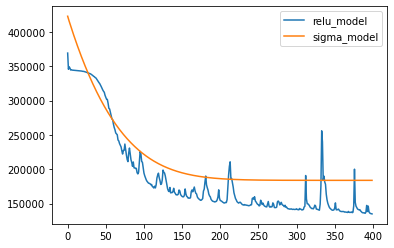

In [26]:
# обучим обе модели в течение 400 эпох
# и посмотрим на динамику лосса
for m in [relu_model, sigma_model]:
    history = m.fit(x_train, y_train,
                    batch_size=50000,
                    epochs=400)
    plt.plot(history.history['loss'])

plt.legend(['relu_model', 'sigma_model'])
plt.show()

Как можно видеть, нейросеть с сигмоидой обучается куда менее "охотно" (и это-то при разнице lr в 100 раз!), а потом и вовсе застревает на месте. 

Есть немало способов попробовать побороться с этим, но проще всего банально использовать другие функции активации.